#Hospital Italiano de Buenos Aires Skin Lesions Images (2019-2022) Dataset

In this notebook, we present the exploratory data analysis (EDA) performed for the Hospital Italiano de Buenos Aires Skin Lesions Images (2019-2022) Dataset (available at https://doi.org/10.34970/587329). The results are consistent with the description presented in the corresponding section of the manuscript.

##Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
!pip install isic-cli

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.8/218.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.1 MB/s eta 0:00:00


##Dataset download

The dataset is registered as a collection in the International Skin Imaging Collaboration (ISIC) archive. It can be accessed through this [link](https://doi.org/10.34970/432362). We resort to the official command line tool for interacting with the ISIC Archive to download images and the corresponding metadata.  

In [3]:
!isic collection list

Psst, you're logged out. Logging in with `isic user login` might return more data.

┏━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ ID  ┃ Name                      ┃ Public ┃ Pinned ┃ Locked ┃ DOI             ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 249 │ BCN20000                  │ True   │ False  │ False  │ None            │
│ 61  │ Challenge 2016: Test      │ True   │ True   │ True   │ None            │
│ 74  │ Challenge 2016: Training  │ True   │ True   │ True   │ None            │
│ 69  │ Challenge 2017: Test      │ True   │ True   │ True   │ None            │
│ 60  │ Challenge 2017: Training  │ True   │ True   │ True   │ None            │
│ 71  │ Challenge 2017:           │ True   │ True   │ True   │ None            │
│     │ Validation                │        │        │        │                 │
│ 64  │ Challenge 2018: Task 1-2: │ True   │ True   │ True   │ None            │
│     │ Test             

###Metadata

In [4]:
os.makedirs('./Data', exist_ok=True)

In [5]:
collection_id = 251
!isic metadata download -c $collection_id -o ./Data/HIBA_dataset.csv

Psst, you're logged out. Logging in with `isic user login` might return more data.



In [6]:
data = pd.read_csv('./Data/HIBA_dataset.csv')
data['image_type'] = data['image_type'].str.replace('clinical: close-up','clinical').replace('clinical: overview','clinical')
data

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,benign_malignant,dermoscopic_type,diagnosis,diagnosis_confirm_type,family_hx_mm,image_type,lesion_id,patient_id,personal_hx_mm,pixels_x,pixels_y,sex
0,ISIC_6230191,Hospital Italiano de Buenos Aires,CC-BY,25.0,anterior torso,malignant,contact polarized,melanoma,histopathology,NaN,dermoscopic,IL_8124990,IP_8542863,True,640,480,male
1,ISIC_4485929,Hospital Italiano de Buenos Aires,CC-BY,65.0,anterior torso,benign,contact polarized,seborrheic keratosis,NaN,NaN,dermoscopic,IL_1921228,IP_9326183,True,2448,2448,female
2,ISIC_3079785,Hospital Italiano de Buenos Aires,CC-BY,45.0,lower extremity,benign,contact polarized,nevus,histopathology,False,dermoscopic,IL_3797557,IP_4906546,False,640,480,male
3,ISIC_9677008,Hospital Italiano de Buenos Aires,CC-BY,30.0,posterior torso,malignant,contact polarized,melanoma,histopathology,NaN,dermoscopic,IL_3556705,IP_5493434,True,1409,2900,female
4,ISIC_9129115,Hospital Italiano de Buenos Aires,CC-BY,75.0,posterior torso,benign,NaN,actinic keratosis,histopathology,NaN,clinical,IL_2485486,IP_8947694,NaN,498,1026,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611,ISIC_6874409,Hospital Italiano de Buenos Aires,CC-BY,75.0,lower extremity,malignant,NaN,basal cell carcinoma,histopathology,NaN,clinical,IL_7279125,IP_4513580,NaN,1420,1602,female
1612,ISIC_4385084,Hospital Italiano de Buenos Aires,CC-BY,75.0,lower extremity,malignant,contact polarized,basal cell carcinoma,histopathology,NaN,dermoscopic,IL_7279125,IP_4513580,NaN,1738,3574,female
1613,ISIC_9314666,Hospital Italiano de Buenos Aires,CC-BY,55.0,head/neck,benign,contact polarized,actinic keratosis,histopathology,NaN,dermoscopic,IL_1313631,IP_7048742,NaN,1918,933,female
1614,ISIC_8229835,Hospital Italiano de Buenos Aires,CC-BY,65.0,posterior torso,malignant,NaN,basal cell carcinoma,histopathology,NaN,clinical,IL_9261445,IP_4577038,NaN,457,304,male


In [21]:
#include supplementary data in the dataframe
sup_data = pd.read_csv('./Data/SupplementaryData.csv')
sup_data.head(2)

,isic_id,skin_type
0,ISIC_6230191,II
1,ISIC_4485929,I


In [24]:
data = data.merge(sup_data, on='isic_id')
data.head()

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,benign_malignant,dermoscopic_type,diagnosis,diagnosis_confirm_type,family_hx_mm,image_type,lesion_id,patient_id,personal_hx_mm,pixels_x,pixels_y,sex,skin_type
0,ISIC_6230191,Hospital Italiano de Buenos Aires,CC-BY,25.0,anterior torso,malignant,contact polarized,melanoma,histopathology,NaN,dermoscopic,IL_8124990,IP_8542863,True,640,480,male,II
1,ISIC_4485929,Hospital Italiano de Buenos Aires,CC-BY,65.0,anterior torso,benign,contact polarized,seborrheic keratosis,NaN,NaN,dermoscopic,IL_1921228,IP_9326183,True,2448,2448,female,I
2,ISIC_3079785,Hospital Italiano de Buenos Aires,CC-BY,45.0,lower extremity,benign,contact polarized,nevus,histopathology,False,dermoscopic,IL_3797557,IP_4906546,False,640,480,male,II
3,ISIC_9677008,Hospital Italiano de Buenos Aires,CC-BY,30.0,posterior torso,malignant,contact polarized,melanoma,histopathology,NaN,dermoscopic,IL_3556705,IP_5493434,True,1409,2900,female,II
4,ISIC_9129115,Hospital Italiano de Buenos Aires,CC-BY,75.0,posterior torso,benign,NaN,actinic keratosis,histopathology,NaN,clinical,IL_2485486,IP_8947694,NaN,498,1026,female,II


###Images

In [7]:
!isic image download --collections $collection_id images/

Psst, you're logged out. Logging in with `isic user login` might return more data.


Successfully downloaded 1,616 images to images/.
Successfully wrote 1,616 metadata records to images/metadata.csv.
Successfully wrote attributions to images/attribution.txt.
Successfully wrote 1 license(s) to images/licenses.


## Exploratory Data Analysis

### Patient, Lesions and Images distribution

In [25]:
lesions_per_patient = []
images_per_patient = []
derm_per_patient = []
clin_per_patient = []

for pat in data.patient_id.unique():
  aux = data[data.patient_id==pat]
  lesions_per_patient.append(len(aux.lesion_id.unique()))
  images_per_patient.append(len(aux))
  derm_per_patient.append(len(aux[aux.image_type=='dermoscopic']))
  clin_per_patient.append(len(aux[aux.image_type=='clinical']))

lesions_per_patient = np.asarray(lesions_per_patient)
images_per_patient = np.asarray(images_per_patient)
derm_per_patient = np.asarray(derm_per_patient)
clin_per_patient = np.asarray(clin_per_patient)

In [26]:
print(f'Total patients in the dataset: {len(data.patient_id.unique())}')

print(f'\nTotal unique lesions: {lesions_per_patient.sum()}')
print(f'Lesions per patient ---> MIN {lesions_per_patient.min()} | MAX {lesions_per_patient.max()} | MEAN {lesions_per_patient.mean()}| MEDIAN {np.median(lesions_per_patient)}')

print(f'\nTotal unique images: {len(data)}')
print(f'Images per patient ---> MIN {images_per_patient.min()} | MAX {images_per_patient.max()} | MEAN {images_per_patient.mean()}| MEDIAN {np.median(images_per_patient)}')

print(f'Dermoscopic images per patient ---> MIN {derm_per_patient.min()} | MAX {derm_per_patient.max()} | MEAN {derm_per_patient.mean()}| MEDIAN {np.median(derm_per_patient)}')

print(f'Clinical images per patient ---> MIN {clin_per_patient.min()} | MAX {clin_per_patient.max()} | MEAN {clin_per_patient.mean()}| MEDIAN {np.median(clin_per_patient)}')

Total patients in the dataset: 623

Total unique lesions: 1246
Lesions per patient ---> MIN 1 | MAX 63 | MEAN 2.0| MEDIAN 1.0

Total unique images: 1616
Images per patient ---> MIN 1 | MAX 63 | MEAN 2.593900481540931| MEDIAN 2.0
Dermoscopic images per patient ---> MIN 0 | MAX 63 | MEAN 2.038523274478331| MEDIAN 1.0
Clinical images per patient ---> MIN 0 | MAX 8 | MEAN 0.5553772070626003| MEDIAN 0.0


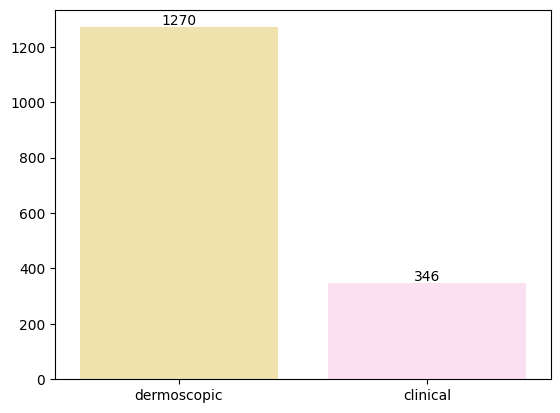

In [27]:
data.image_type.value_counts(dropna=False)

ax = sns.barplot(x=data.image_type.value_counts().keys(), y=data.image_type.value_counts().values, data=data, palette=['#FBE8A1', '#FFDCF4'])
_ = ax.bar_label(ax.containers[0])

In [28]:
images_per_lesion = []
derm_per_lesion = []
clin_per_lesion = []

for pat in data.patient_id.unique():
  aux = data[data.patient_id==pat]

  for les in aux.lesion_id.unique():
    aux2 = aux[aux.lesion_id==les]
    images_per_lesion.append(len(aux2))
    derm_per_lesion.append(len(aux2[aux2.image_type=='dermoscopic']))
    clin_per_lesion.append(len(aux2[aux2.image_type=='clinical']))

images_per_lesion = np.asarray(images_per_lesion)
derm_per_lesion = np.asarray(derm_per_lesion)
clin_per_lesion = np.asarray(clin_per_lesion)

In [29]:
print(f'Total images: {images_per_lesion.sum()}')
print(f'Total dermoscopic images: {derm_per_lesion.sum()}')
print(f'Total clinical images: {clin_per_lesion.sum()}')
print(f'Sum of dermoscopic and clinical images: {derm_per_lesion.sum()+clin_per_lesion.sum()}')

Total images: 1616
Total dermoscopic images: 1270
Total clinical images: 346
Sum of dermoscopic and clinical images: 1616


In [30]:
print(f'Images per lesion ---> MIN {images_per_lesion.min()} | MAX {images_per_lesion.max()} | MEAN {images_per_lesion.mean()}| MEDIAN {np.median(images_per_lesion)}')
print('Total unique lesions', images_per_lesion.sum())

print(f'\nDermoscopic images per lesion ---> MIN {derm_per_lesion.min()} | MAX {derm_per_lesion.max()} | MEAN {derm_per_lesion.mean()}| MEDIAN {np.median(derm_per_lesion)}')

print(f'\nClinical images per lesion ---> MIN {clin_per_lesion.min()} | MAX {clin_per_lesion.max()} | MEAN {clin_per_lesion.mean()}| MEDIAN {np.median(clin_per_lesion)}')

Images per lesion ---> MIN 1 | MAX 6 | MEAN 1.2969502407704654| MEDIAN 1.0
Total unique lesions 1616

Dermoscopic images per lesion ---> MIN 0 | MAX 5 | MEAN 1.0192616372391654| MEDIAN 1.0

Clinical images per lesion ---> MIN 0 | MAX 2 | MEAN 0.27768860353130015| MEDIAN 0.0


### Patient characteristics

In [38]:
patient_data = data[['patient_id','age_approx', 'sex','personal_hx_mm', 'family_hx_mm', 'skin_type']].reset_index(drop=True) #at the time of consultation
patient_data.drop_duplicates(['patient_id'],inplace=True)
patient_data.reset_index(inplace=True,drop=True)
patient_data

,patient_id,age_approx,sex,personal_hx_mm,family_hx_mm,skin_type
0,IP_8542863,25.0,male,True,NaN,II
1,IP_9326183,65.0,female,True,NaN,I
2,IP_4906546,45.0,male,False,False,II
3,IP_5493434,30.0,female,True,NaN,II
4,IP_8947694,75.0,female,NaN,NaN,II
...,...,...,...,...,...,...
618,IP_6251525,75.0,female,True,False,II
619,IP_4132519,25.0,female,False,False,II
620,IP_4513580,75.0,female,NaN,NaN,II
621,IP_7048742,55.0,female,NaN,NaN,II


####Age

Patient/s without age_approx informed:  5
Corresponding %:  0.8025682182985553

Patients age ---> MIN 20.0 | MAX 85.0 | MEAN 62.127831715210355 | SD 17.34981404738759


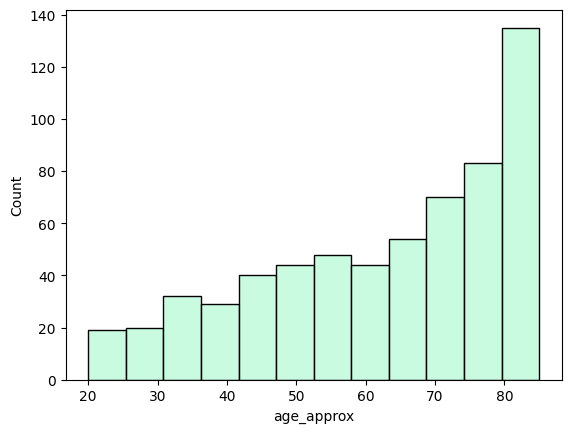

In [32]:
patient_data.age_approx = patient_data.age_approx.replace('', np.nan)
patient_data.age_approx = patient_data.age_approx.astype('float')

pvc = patient_data.age_approx.value_counts(dropna=False)
print('Patient/s without age_approx informed: ', pvc[np.nan])
print('Corresponding %: ', (pvc[np.nan]/len(patient_data)*100))

print(f'\nPatients age ---> MIN {patient_data.age_approx.min()} | MAX {patient_data.age_approx.max()} | MEAN {patient_data.age_approx.mean()} | SD {patient_data.age_approx.std()}')


_ = sns.histplot(patient_data.age_approx, color='#B7FAD7')

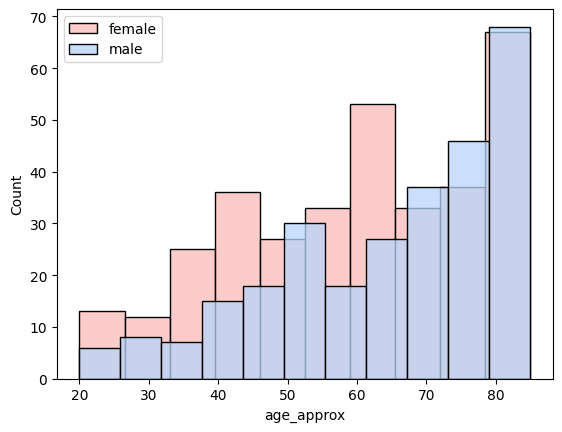

In [33]:
female_px = patient_data[patient_data.sex=='female']
male_px = patient_data[patient_data.sex=='male']
_ = sns.histplot(female_px.age_approx, color='#FABCB7', label='female')
_ = sns.histplot(male_px.age_approx, color='#B7D5FA', label='male')
_ = plt.legend()

####Sex

In [34]:
patient_data.sex = patient_data.sex.replace('', np.nan)
pvc = patient_data.sex.value_counts(dropna=False)
print('Patient/s without sex informed: ', pvc[np.nan])
print('Corresponding %: ', (pvc[np.nan]/len(patient_data)*100) )

print('\nTotal female patients: ', len(female_px))
print('Total male patients: ', len(male_px))
print('Total patients: ', len(female_px)+len(male_px)+pvc[np.nan])

Patient/s without sex informed:  2
Corresponding %:  0.32102728731942215

Total female patients:  339
Total male patients:  282
Total patients:  623


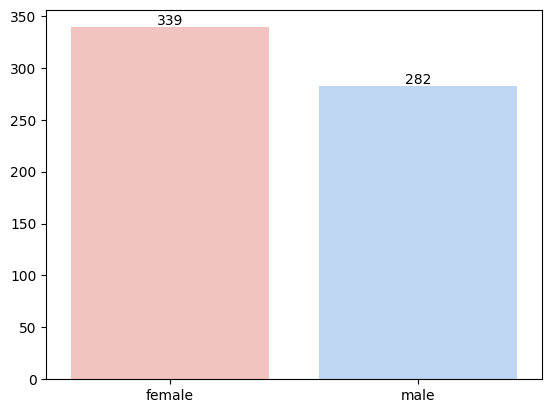

In [35]:
ax = sns.barplot(x=patient_data.sex.value_counts(dropna=False).keys(), y=patient_data.sex.value_counts(dropna=False).values, data=patient_data, palette=['#FABCB7', '#B7D5FA'])
_ = ax.bar_label(ax.containers[0])

####Skin tone

In [48]:
pvc = patient_data.skin_type.value_counts(dropna=False)

print('Image/s with skin type informed: ', data.skin_type.value_counts().sum())
print('Corresponding %: ', (data.skin_type.value_counts().sum()/len(data)*100) )

print('\nImage/s without skin type informed: ', data.skin_type.value_counts(dropna=False)[np.nan])
print('Corresponding %: ', (data.skin_type.value_counts(dropna=False)[np.nan]/len(data)*100) )


Image/s with skin type informed:  1499
Corresponding %:  92.75990099009901

Image/s without skin type informed:  117
Corresponding %:  7.240099009900989


In [44]:
pvc = patient_data.skin_type.value_counts(dropna=False)

print('Patient/s with skin type informed: ', patient_data.skin_type.value_counts().sum())
print('Corresponding %: ', (patient_data.skin_type.value_counts().sum()/len(patient_data)*100) )

print('\nPatient/s without skin type informed: ', pvc[np.nan])
print('Corresponding %: ', (pvc[np.nan]/len(patient_data)*100) )


Patient/s with skin type informed:  566
Corresponding %:  90.85072231139647

Patient/s without skin type informed:  57
Corresponding %:  9.149277688603531


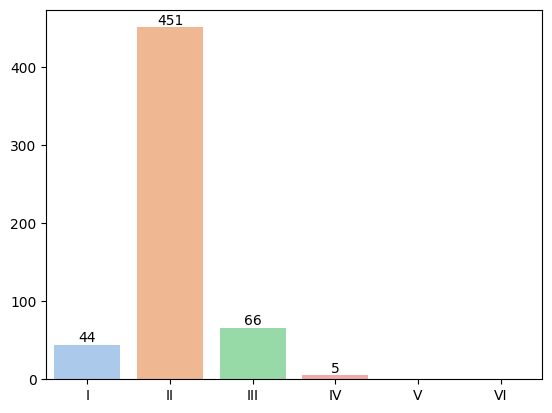

In [43]:
ax = sns.barplot(x=patient_data.skin_type.value_counts(dropna=False).keys(), y=patient_data.skin_type.value_counts(dropna=False).values, data=patient_data, palette='pastel', order=['I','II', 'III', 'IV', 'V', 'VI'])
_ = ax.bar_label(ax.containers[0])

####Personal and Familiy History of Melanoma

Possible combinations PERSONAL_HISTORY - FAMILIY_HISTORY

* Unk-Unk
* Unk-True
* Unk-False
* True-Unk
* False-Unk
* True-True
* True-False
* False-False
* False-True

In [ ]:
print('Personal History of Melanoma\n')
patient_data.personal_hx_mm = patient_data.personal_hx_mm.replace('', np.nan)
patient_data.personal_hx_mm.value_counts(dropna=False)

Personal History of Melanoma



NaN      339
True     150
False    134
Name: personal_hx_mm, dtype: int64

In [ ]:
print('Family History of Melanoma\n')
patient_data.family_hx_mm = patient_data.family_hx_mm.replace('', np.nan)
patient_data.family_hx_mm.value_counts(dropna=False)

Family History of Melanoma



NaN      386
False    206
True      31
Name: family_hx_mm, dtype: int64

In [ ]:
print('Different combination of Personal and Family History of Melanoma\n')
unk_unk = patient_data[(patient_data.personal_hx_mm.isnull()) & (patient_data.family_hx_mm.isnull())]
print('> Unkown - Unknown  ', len(unk_unk))

unk_true = patient_data[(patient_data.personal_hx_mm.isnull()) & (patient_data.family_hx_mm==True)]
print('> Unkown - True     ', len(unk_true))

unk_false = patient_data[(patient_data.personal_hx_mm.isnull()) & (patient_data.family_hx_mm==False)]
print('> Unkown - False    ', len(unk_false))

true_unk = patient_data[(patient_data.personal_hx_mm==True) & (patient_data.family_hx_mm.isnull())]
print('> True - Unknown    ', len(true_unk))

false_unk = patient_data[(patient_data.personal_hx_mm==False) & (patient_data.family_hx_mm.isnull())]
print('> False - Unknown   ', len(false_unk))

true_true = patient_data[(patient_data.personal_hx_mm==True) & (patient_data.family_hx_mm==True)]
print('> True - True       ', len(true_true))

true_false = patient_data[(patient_data.personal_hx_mm==True) & (patient_data.family_hx_mm==False)]
print('> True - False      ', len(true_false))

false_false = patient_data[(patient_data.personal_hx_mm==False) & (patient_data.family_hx_mm==False)]
print('> False - False     ', len(false_false))

false_true = patient_data[(patient_data.personal_hx_mm==False) & (patient_data.family_hx_mm==True)]
print('> False - True      ', len(false_true))

Different combination of Personal and Family History of Melanoma

> Unkown - Unknown   333
> Unkown - True      6
> Unkown - False     0
> True - Unknown     48
> False - Unknown    5
> True - True        7
> True - False       95
> False - False      111
> False - True       18


In [ ]:
total_px = len(patient_data)
least_one_unk = len(unk_unk)+len(unk_true)+len(unk_false)+len(true_unk)+len(false_unk)

print(f'At least one history record is unknown: {(least_one_unk/total_px)*100} %')

At least one history record is unknown: 62.92134831460674 %


In [ ]:
unk_unk = patient_data[(patient_data.personal_hx_mm.isnull()) & (patient_data.family_hx_mm.isnull())]
print(f'Unknown personal and family history of MM:  {len(unk_unk)} - {(len(unk_unk)/total_px)*100} %')

pvc = patient_data.personal_hx_mm.value_counts(dropna=False)
print(f'\nPersonal history of MM: \n  {(pvc[np.nan]/total_px)*100} % unknown \n  {(pvc[True]/total_px)*100} % yes \n  {(pvc[False]/total_px)*100} % no')

pvc = patient_data.family_hx_mm.value_counts(dropna=False)
print(f'\nFamily history of MM: \n  {(pvc[np.nan]/total_px)*100} % unknown \n  {(pvc[True]/total_px)*100} % yes \n  {(pvc[False]/total_px)*100} % no')

false_false_p = patient_data[(patient_data.personal_hx_mm==False) & (patient_data.family_hx_mm==False)]
print(f'\nNegative personal and family history of MM {(len(false_false_p)/total_px)*100} %')

true_true_p = patient_data[(patient_data.personal_hx_mm==True) & (patient_data.family_hx_mm==True)]
print(f'\nPositive personal and family history of MM {(len(true_true_p)/total_px)*100} %')

Unknown personal and family history of MM:  333 - 53.45104333868379 %

Personal history of MM: 
  54.41412520064205 % unknown 
  24.077046548956663 % yes 
  21.508828250401287 % no

Family history of MM: 
  61.95826645264848 % unknown 
  4.975922953451043 % yes 
  33.06581059390048 % no

Negative personal and family history of MM 17.81701444622793 %

Positive personal and family history of MM 1.1235955056179776 %


###Lesion characteristics

In [ ]:
lesion_data = data[['patient_id','lesion_id','benign_malignant', 'diagnosis','diagnosis_confirm_type', 'anatom_site_general']]
lesion_data.head()

,patient_id,lesion_id,benign_malignant,diagnosis,diagnosis_confirm_type,anatom_site_general
0,IP_8542863,IL_8124990,malignant,melanoma,histopathology,anterior torso
1,IP_9326183,IL_1921228,benign,seborrheic keratosis,NaN,anterior torso
2,IP_4906546,IL_3797557,benign,nevus,histopathology,lower extremity
3,IP_5493434,IL_3556705,malignant,melanoma,histopathology,posterior torso
4,IP_8947694,IL_2485486,benign,actinic keratosis,histopathology,posterior torso


In [ ]:
lesion_data.drop_duplicates(['patient_id', 'lesion_id'], inplace=True)
len(lesion_data)

<ipython-input-62-33b72bba6122>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lesion_data.drop_duplicates(['patient_id', 'lesion_id'], inplace=True)


1246

####Diagnosis - Confirmation - Benign/Malignant

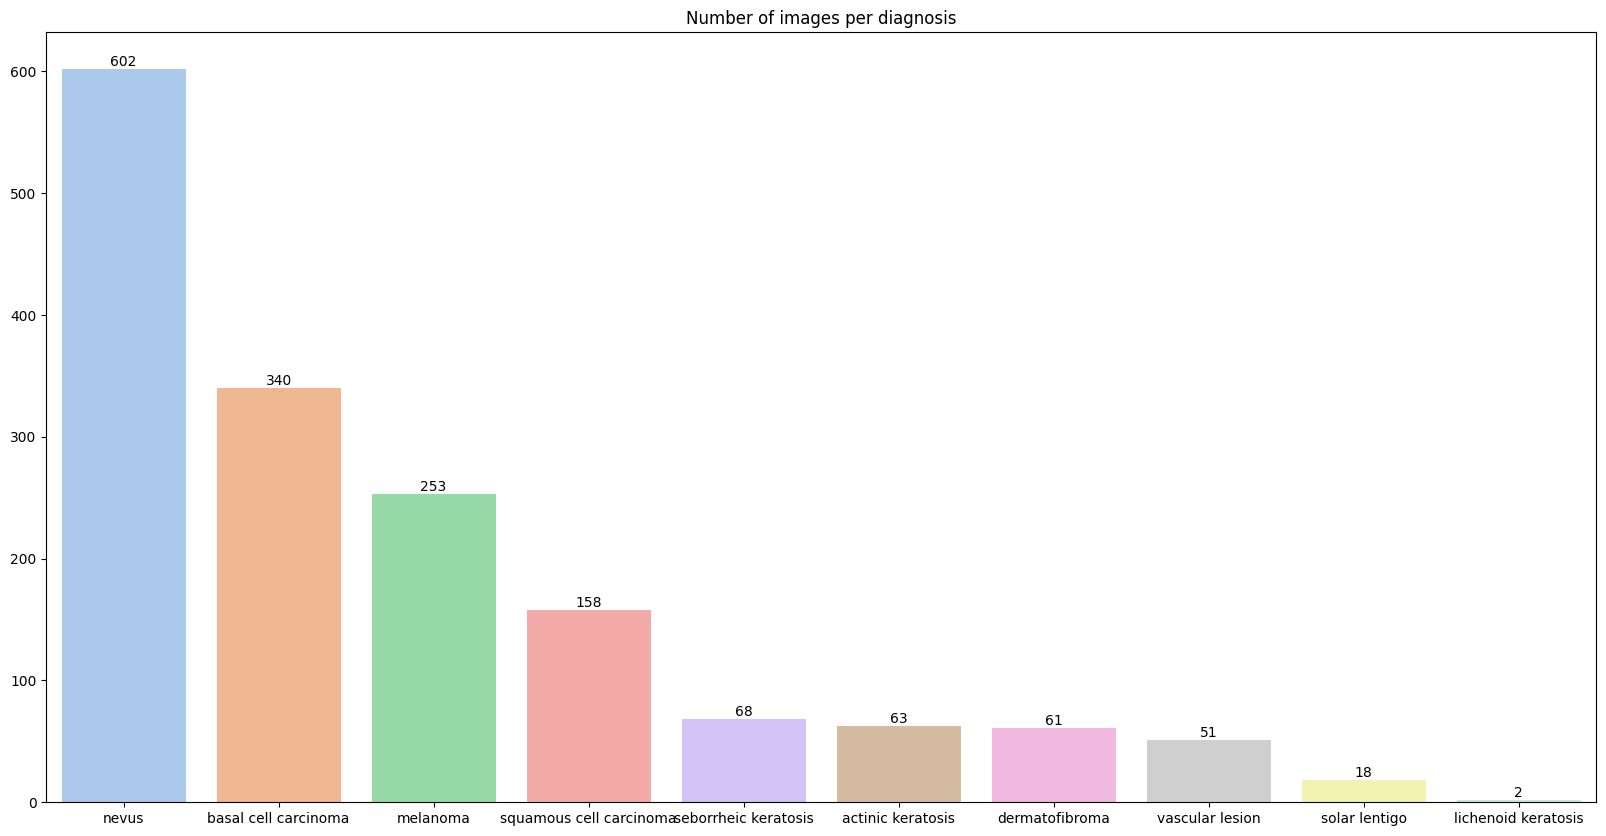

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x=data.diagnosis.value_counts().keys(), y=data.diagnosis.value_counts().values, data=data, palette='pastel')
ax.set_title('Number of images per diagnosis')
_ = ax.bar_label(ax.containers[0])

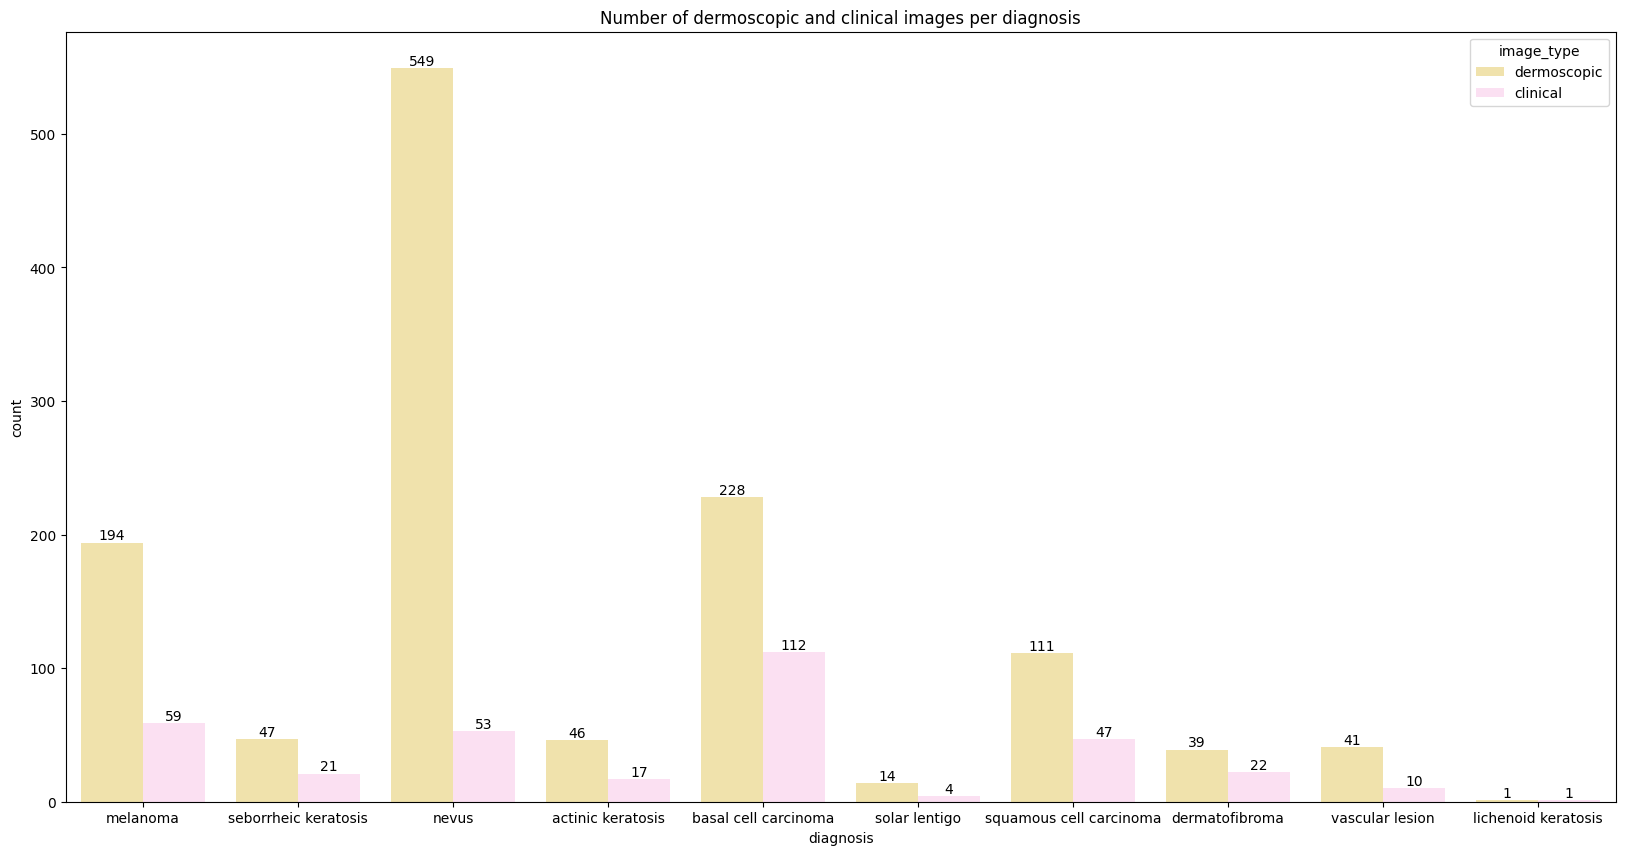

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(x='diagnosis', hue='image_type', data=data, palette=['#FBE8A1', '#FFDCF4'])
ax.set_title('Number of dermoscopic and clinical images per diagnosis')
_ = ax.bar_label(ax.containers[0])
_ = ax.bar_label(ax.containers[1])

There are 751 malignant images which represent the 46.472772277227726% of the dataset


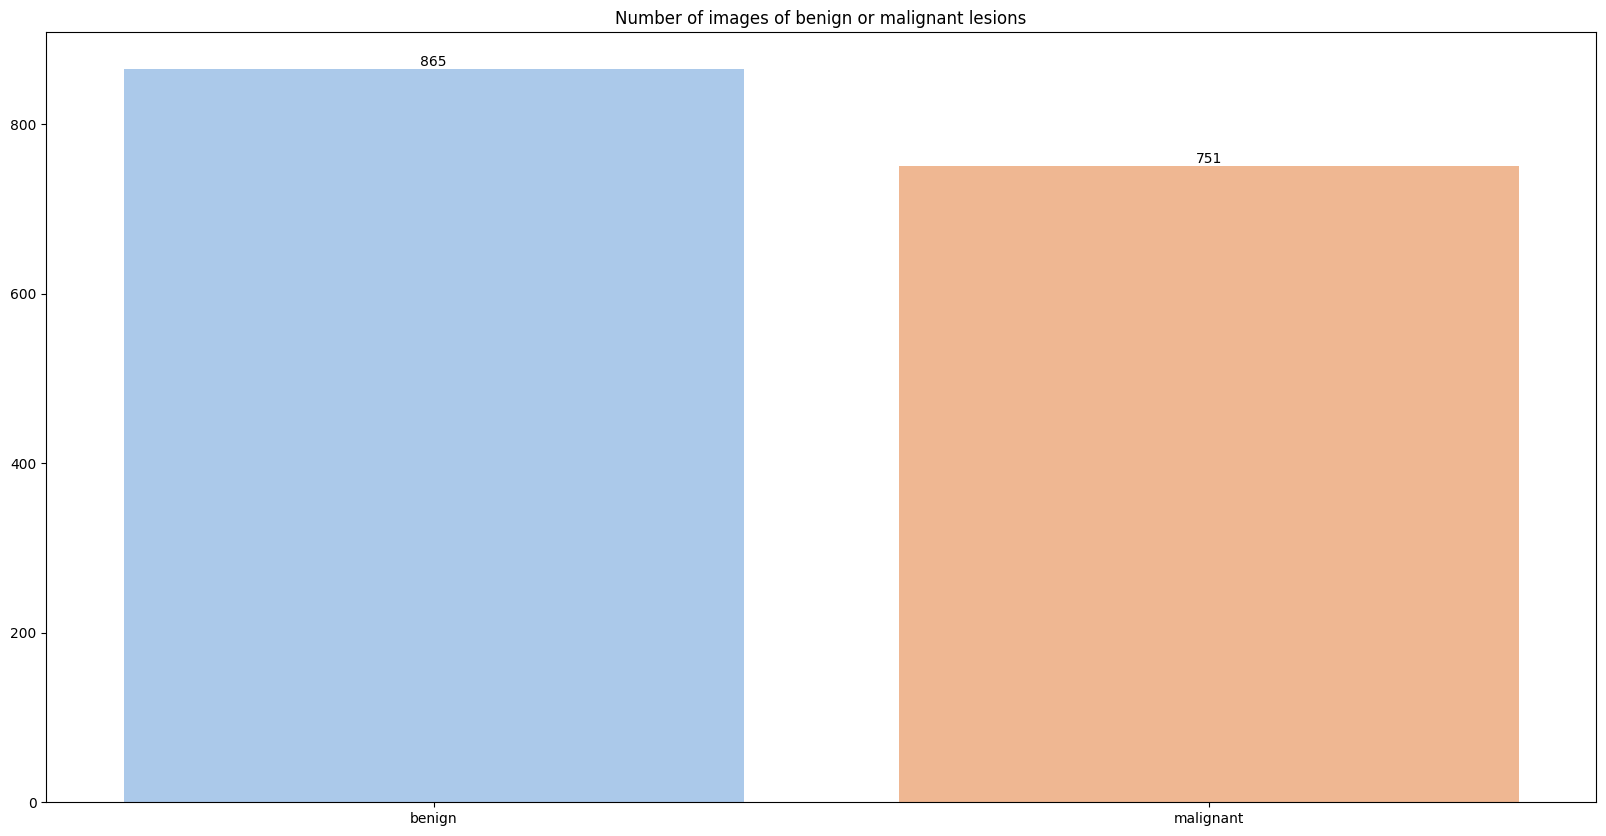

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x=data.benign_malignant.value_counts().keys(), y=data.benign_malignant.value_counts().values, data=data, palette='pastel')
ax.set_title('Number of images of benign or malignant lesions')
_ = ax.bar_label(ax.containers[0])
print(f"There are {data.benign_malignant.value_counts()['malignant']} malignant images which represent the {data.benign_malignant.value_counts()['malignant']/len(data)*100}% of the dataset")

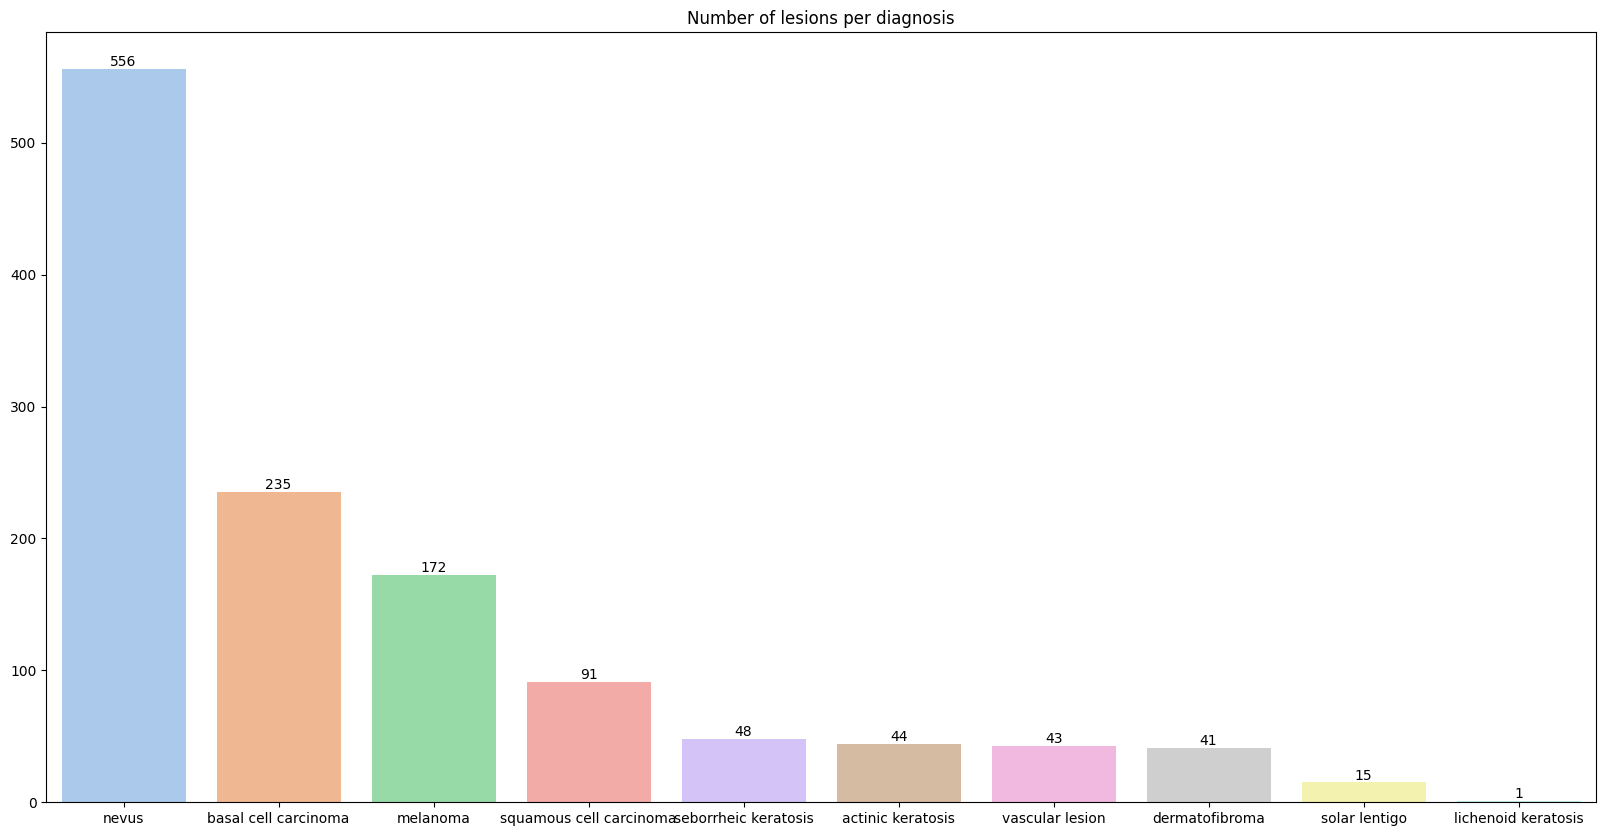

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x=lesion_data.diagnosis.value_counts().keys(), y=lesion_data.diagnosis.value_counts().values, data=lesion_data, palette='pastel')
ax.set_title('Number of lesions per diagnosis')
_=ax.bar_label(ax.containers[0])

There are 498 malignant lesions which represent the 39.96789727126806% of the dataset


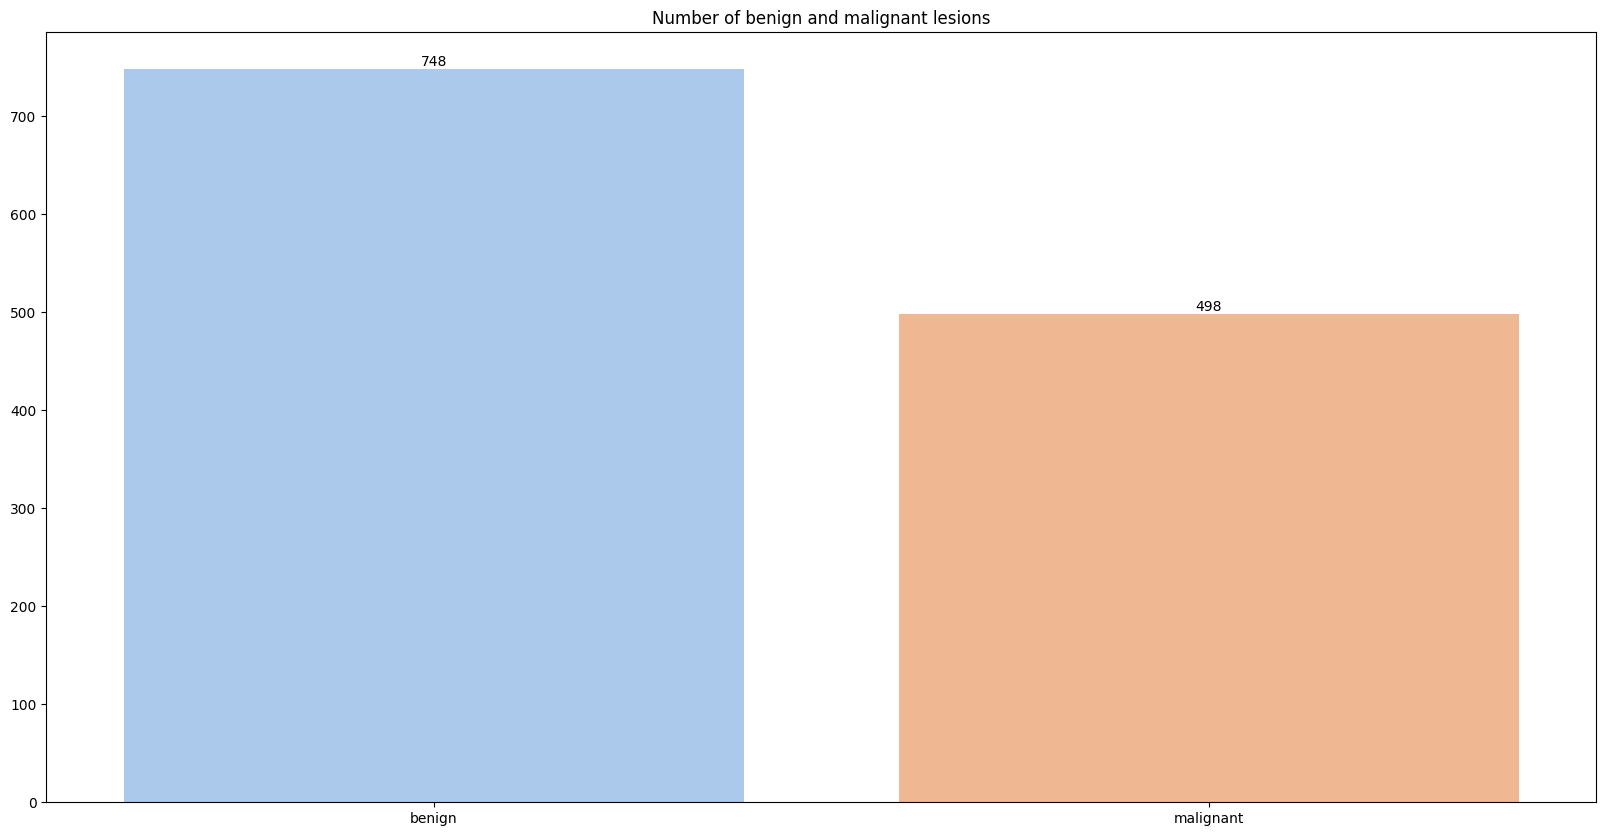

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x=lesion_data.benign_malignant.value_counts().keys(), y=lesion_data.benign_malignant.value_counts().values, data=data, palette='pastel')
ax.set_title('Number of benign and malignant lesions')
_ = ax.bar_label(ax.containers[0])
print(f"There are {lesion_data.benign_malignant.value_counts()['malignant']} malignant lesions which represent the {lesion_data.benign_malignant.value_counts()['malignant']/len(lesion_data)*100}% of the dataset")

<ipython-input-68-2a6f2c281448>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lesion_data.diagnosis_confirm_type = lesion_data.diagnosis_confirm_type.replace('', 'single expert criteria')


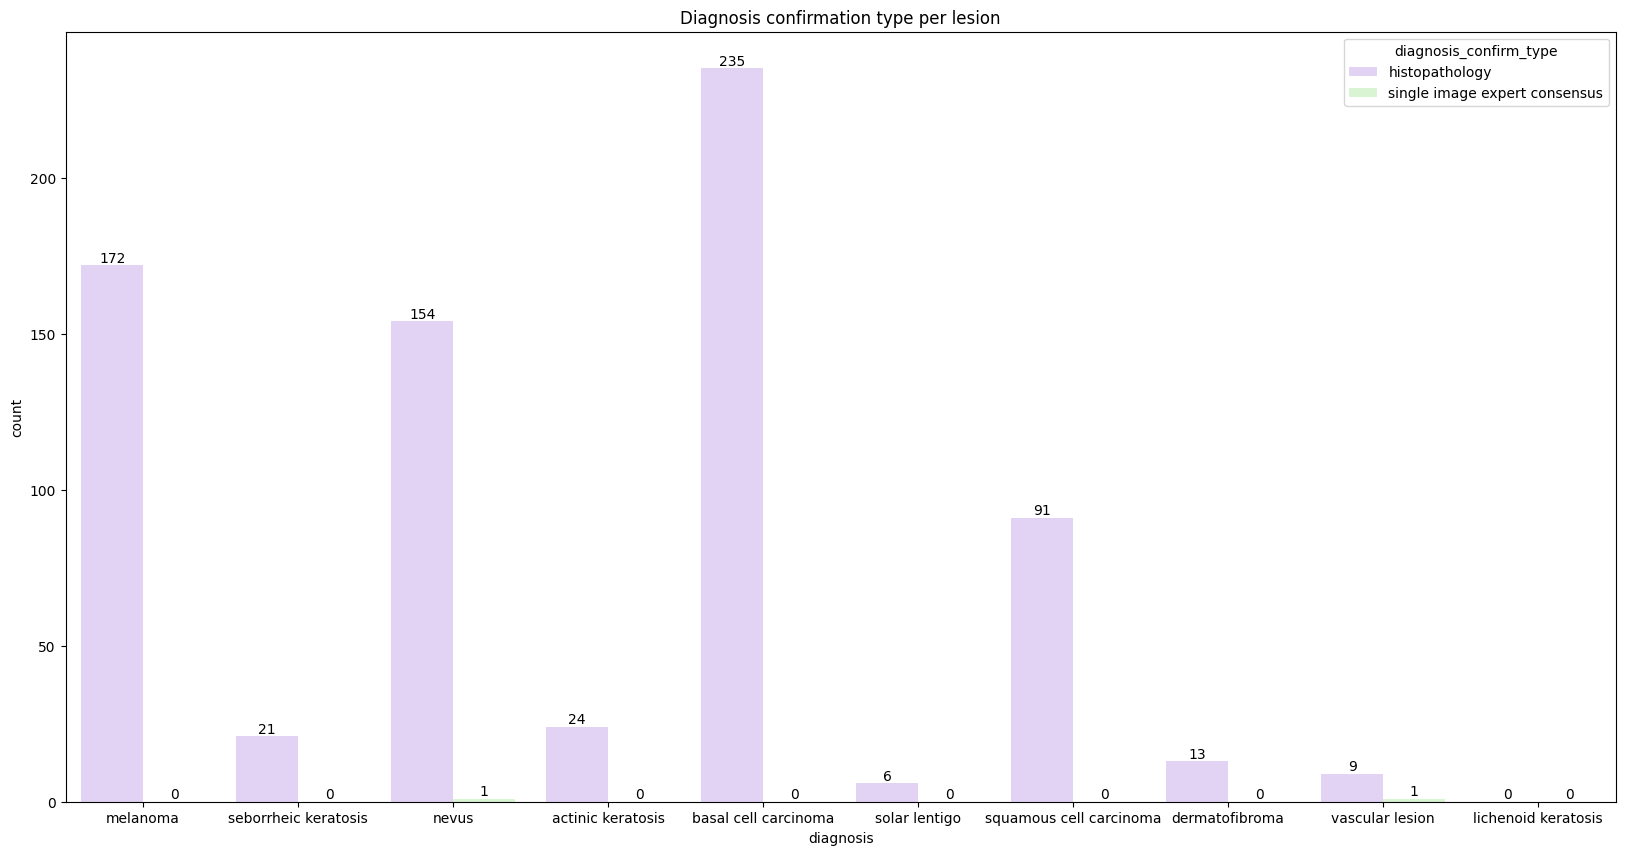

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
lesion_data.diagnosis_confirm_type = lesion_data.diagnosis_confirm_type.replace('', 'single expert criteria')
ax = sns.countplot(x='diagnosis', hue='diagnosis_confirm_type', data=lesion_data, palette=['#E1CEF9', '#D4F9CE', '#CEE5F9'])
ax.set_title('Diagnosis confirmation type per lesion')
for i,v in enumerate(lesion_data.diagnosis_confirm_type.unique()):
  try:
    _=ax.bar_label(ax.containers[i])
  except:
    continue

In [ ]:
for d in lesion_data.diagnosis.unique():
  try:
    aux = lesion_data[lesion_data.diagnosis==d]
    lvc = aux.diagnosis_confirm_type.value_counts()
    print(f'\n{d} --> {len(aux)} lesions - {lvc["histopathology"]} biopsy-proven lesions - {(lvc["histopathology"]/len(aux))*100} % Histopathology Confirmation')
  except Exception as e:
    print(f'\nFor lesion {d}, there is no confirmation by {e}')


melanoma --> 172 lesions - 172 biopsy-proven lesions - 100.0 % Histopathology Confirmation

seborrheic keratosis --> 48 lesions - 21 biopsy-proven lesions - 43.75 % Histopathology Confirmation

nevus --> 556 lesions - 154 biopsy-proven lesions - 27.697841726618705 % Histopathology Confirmation

actinic keratosis --> 44 lesions - 24 biopsy-proven lesions - 54.54545454545454 % Histopathology Confirmation

basal cell carcinoma --> 235 lesions - 235 biopsy-proven lesions - 100.0 % Histopathology Confirmation

solar lentigo --> 15 lesions - 6 biopsy-proven lesions - 40.0 % Histopathology Confirmation

squamous cell carcinoma --> 91 lesions - 91 biopsy-proven lesions - 100.0 % Histopathology Confirmation

dermatofibroma --> 41 lesions - 13 biopsy-proven lesions - 31.70731707317073 % Histopathology Confirmation

vascular lesion --> 43 lesions - 9 biopsy-proven lesions - 20.930232558139537 % Histopathology Confirmation

For lesion lichenoid keratosis, there is no confirmation by 'histopatholo

In [ ]:
print(f'\nTotal Histopathology Confirmation: {lesion_data.diagnosis_confirm_type.value_counts()["histopathology"]} lesions ({(lesion_data.diagnosis_confirm_type.value_counts()["histopathology"]/len(lesion_data))*100} %)')


Total Histopathology Confirmation: 725 lesions (58.18619582664526 %)


In [ ]:
print(f'\nTotal Histopathology Confirmation: {data.diagnosis_confirm_type.value_counts()["histopathology"]} images ({(data.diagnosis_confirm_type.value_counts()["histopathology"]/len(data))*100} %)')


Total Histopathology Confirmation: 1036 images (64.10891089108911 %)


####General Anatomical Site

In [ ]:
lesion_data.anatom_site_general = lesion_data.anatom_site_general.replace('', np.nan)
lesion_data.anatom_site_general.value_counts(dropna=False)

<ipython-input-72-0b5b68988fea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lesion_data.anatom_site_general = lesion_data.anatom_site_general.replace('', np.nan)


head/neck          281
posterior torso    260
lower extremity    233
anterior torso     210
upper extremity    130
NaN                100
palms/soles         17
lateral torso        9
oral/genital         6
Name: anatom_site_general, dtype: int64

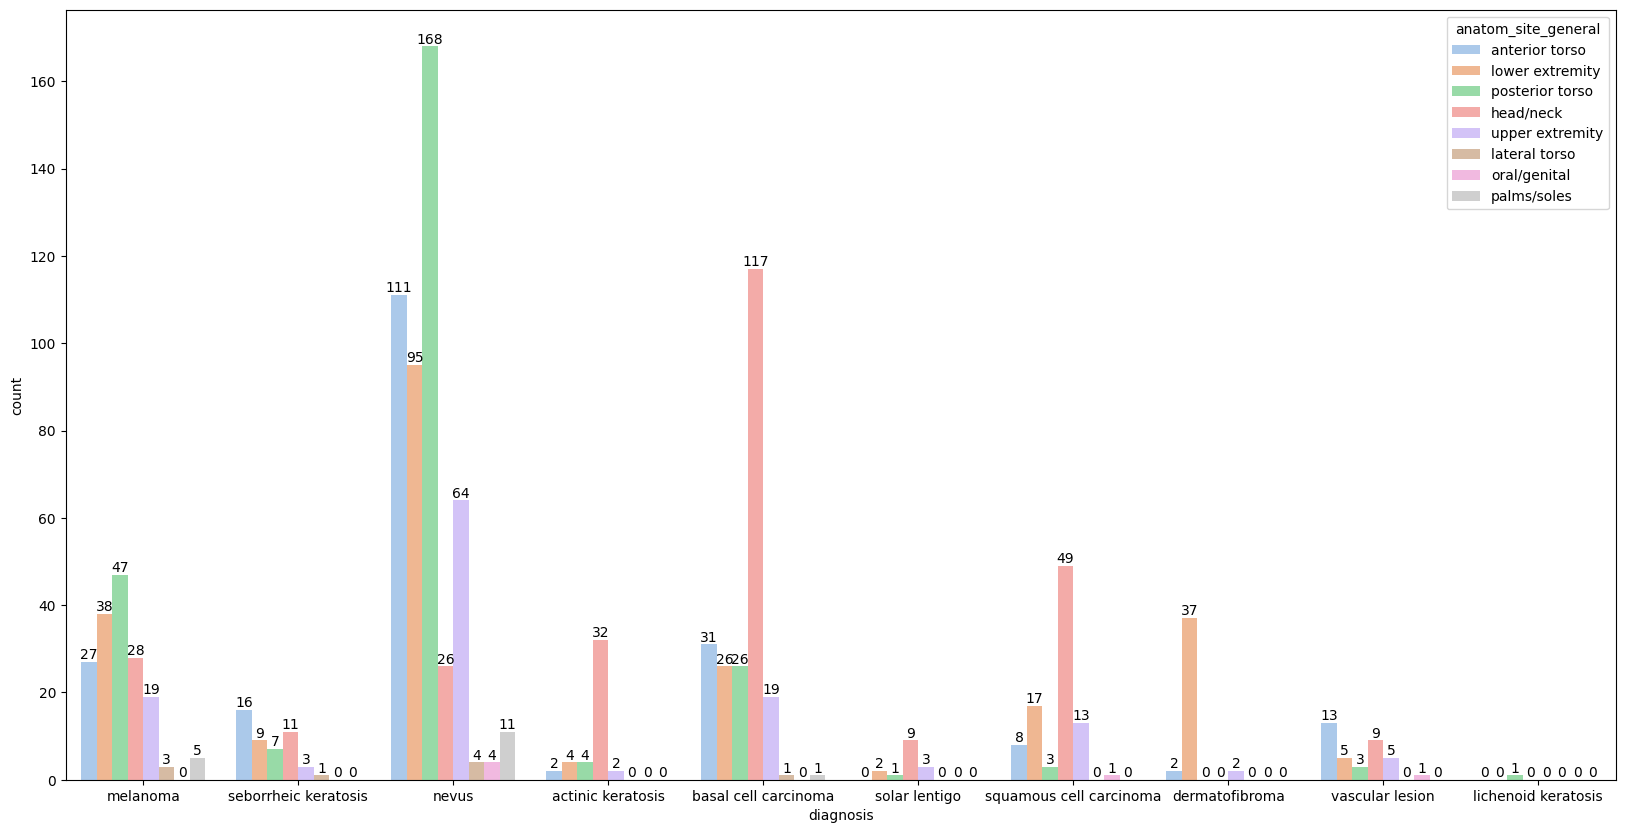

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(x='diagnosis', hue='anatom_site_general', data=lesion_data, palette='pastel')
for i,v in enumerate(lesion_data.anatom_site_general.unique()):
  try:
    ax.bar_label(ax.containers[i])
  except:
    continue